# Classification & Detection of Singapore Road Traffic Signs:<br>[Part 2] Object Detection via Tensorflow Object Detection API

## Data Collection

### Import all necessary libraries

In [1]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from shutil import copyfile
from PIL import Image, ImageDraw
from statistics import mean 

from skmultilearn.model_selection import IterativeStratification

### Recalling the data-collection process for classification

Image data required for performing object detection is different from that of classification. We re-visit the data collection process for classification:

<img src='./Images/classification_data_collection_process.png' />


The last step was specifically performed for generating cropped images of traffic signs. The result is a an image file with the targeted traffic sign was front and center, occupying nearly the whole real estate of the image.

### Altering data-collection process to include class annotation

For object detection, we are concerned with:

1) locating a sign within a given frame
<br>2) classifying the sign in the proposed location

Therefore, we will modify last step in the original data collection process to be as follows (see yellow box):

<img src='./Images/object_detection_data_collection_process.png' />

### Class annotation with `labelImg` tool

Class annotation of traffic signs was performed using [LabelImg](https://github.com/tzutalin/labelImg). 

This image-annotation tool allows us to define bounding boxes on a target class, such as the *Prohibitory No Vehicles over Height 4.5m* traffic sign in the image below, assign a label, and save the annotation metadata.

<img src='./Images/labelImg_example.jpg' />

LabelImg also provides a means to traverse a folder of images, as well as maintains a list of labels for repeated usage.

<img src='./Images/labelImg_example_2.jpg' />

The annotation metadata is saved a XML file of similar filename with the annotated image. As shown above, the Pascal Visual Object Classes (VOC) data format is used to maintain the bounding box (see *xmin*, *ymin*, *xmax* and *ymax* elements) and label (see *name* element) information. 

For an image containing multiple traffic signs, it would still have 1 annotation XML file associated with it, but the file would contain multiple *object* elements, each denoting the label position of the targeted traffic sign.

### Aggregate all XML annotations into a single CSV file

A single CSV file containing all annotation data is required for data pre-processing phase later, but can be compiled at this point to aid exploratory data analysis.

### Declare locations of various dataset and assets

**Note**: All locations must be set correctly in order to facilitate correct ingestion and creation of respective data assets.

In [2]:
# SET THIS PATH TO POINT TO FOLDER WITH ALL JPEG IMAGES AND THEIR RESPECTIVE ANNOTATION XML FILES (VOC FORMAT)
# 
img_and_xml_dir_path = 'E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION/'

tfrecord_base_dir_path = 'E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/'
train_dir_path = tfrecord_base_dir_path + 'train/'
test_dir_path = tfrecord_base_dir_path + 'test/'
validation_dir_path = tfrecord_base_dir_path + 'validation/'

train_img_dir_path = 'E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/'
test_img_dir_path = 'E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TEST/'
validation_img_dir_path = 'E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_VALIDATION/'

#### Define helper method to aggregate all annotation XML files

In [3]:
def annotation_xml_to_dataframe(path):
    if not os.path.isdir(path):
        print('path parameter [{}] not found'.format(path))
        return None
    else:
        # declare xml_list to hold annotation data records
        xml_list = []
        # iterate through all XML files found in given path
        for xml_file in glob.glob(path + '*.xml'):
            # parse whole file into a XML tree structure
            tree = ET.parse(xml_file)
            # get root element of XML tree
            root = tree.getroot()
            # iterate through every available object element in the XML tree
            for member in root.findall('object'):
                # declare value as an 8-element tuple of various data-points
                value = (root.find('filename').text,     # filename of associated image
                         int(root.find('size')[0].text), # width of image
                         int(root.find('size')[1].text), # height of image
                         member[0].text,                 # label, contained in name element, 1st item in object element
                         int(member[4][0].text),         # xmin coordinate, inside bndbox element
                         int(member[4][1].text),         # ymin coordinate, inside bndbox element
                         int(member[4][2].text),         # xmax coordinate, inside bndbox element
                         int(member[4][3].text)          # ymax coordinate, inside bndbox element
                         )
                # append value to list
                xml_list.append(value)
        # declare meaningful column names
        column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
        # convert xml_list into dataframe with associated column names
        xml_df = pd.DataFrame(xml_list, columns=column_name)
        # return dataframe
        return xml_df

#### Generate dataset

In [4]:
traffic_signs_df = annotation_xml_to_dataframe(img_and_xml_dir_path)

In [5]:
traffic_signs_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,24_s_000060.jpg,1280,720,Mandatory Give Way,799,354,845,401
1,24_s_000090.jpg,1280,720,Mandatory Give Way,923,328,983,383
2,24_s_000120.jpg,1280,720,Mandatory Give Way,1149,268,1238,344
3,24_s_000420.jpg,1280,720,Mandatory Split Way,466,506,507,546
4,24_s_000450.jpg,1280,720,Mandatory Split Way,223,496,282,550
...,...,...,...,...,...,...,...,...
2549,35_s_142810.jpg,1280,720,Mandatory Split Way,1136,494,1203,559
2550,35_s_142950.jpg,1280,720,Directional Sign,129,379,342,463
2551,35_s_143340.jpg,1280,720,Temp Work Zone Sign,128,281,267,405
2552,35_s_143560.jpg,1280,720,Temp Work Zone Sign,436,447,488,501


## Exploratory Data Analysis

### Inspect dataset

In [6]:
traffic_signs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2554 entries, 0 to 2553
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2554 non-null   object
 1   width     2554 non-null   int64 
 2   height    2554 non-null   int64 
 3   class     2554 non-null   object
 4   xmin      2554 non-null   int64 
 5   ymin      2554 non-null   int64 
 6   xmax      2554 non-null   int64 
 7   ymax      2554 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 159.8+ KB


### Verify that number of unique filenames in dataset matches number of image files in designated folder

In [7]:
# Both counts should tally
print('Number of image files in CSV: {}'.format(traffic_signs_df.loc[:,'filename'].nunique()))
print('Number of image files in image folder: {}'.format(len(glob.glob(img_and_xml_dir_path+'*.jpg'))))

Number of image files in CSV: 1560
Number of image files in image folder: 1560


### Sample 10 records from dataset

In [8]:
traffic_signs_df.sample(10)

,filename,width,height,class,xmin,ymin,xmax,ymax
329,24_s_050130.jpg,1280,720,Info TP Camera Zone,879,409,916,468
1653,32_s_008950.jpg,1280,720,Mandatory Give Way,525,421,569,465
1803,32_s_016550.jpg,1280,720,Prohibitory No Jaywalking,81,296,171,378
2464,35_s_074710.jpg,1280,720,Info Rain Shelter,194,351,263,412
94,24_s_007380.jpg,1280,720,Warning Road Hump,372,317,417,361
522,24_s_084410.jpg,1280,720,Info Expway Dist Marker,362,431,396,464
60,24_s_005500.jpg,1280,720,Warning Height Restriction Ahead 4.5m,485,301,527,345
2066,33_s_042640.jpg,1280,720,Info Zebra Crossing,49,323,127,395
2015,33_s_030840.jpg,1280,720,Temp Work Zone Sign,50,522,238,699
187,24_s_032490.jpg,1280,720,Prohibitory Spd Limit 80,309,432,341,462


Dataset for object detection has 2554 annotation records for 1560 images, indicating that a proportion of images has multiple annotations, i.e. more than 1 traffic sign present in a given frame. There are currently no missing values in the remaining 6 numerical columns that provide dimension and coordinate data for each record.

### Investigate distribution of classes

In [9]:
print('Number of unique labels: {}'.format(traffic_signs_df.loc[:,'class'].nunique()))

Number of unique labels: 57


In [16]:
ts_agg_count_by_class = traffic_signs_df.groupby(by=['class']).agg(count=('filename','count'))
ts_agg_count_by_class.loc[:,'class'] = ts_agg_count_by_class.index
ts_agg_count_by_class.reset_index(drop=True, inplace=True)
ts_agg_count_by_class.loc[ts_agg_count_by_class.loc[:,'count']<20, :]

,count,class
1,13,Info Cam Zone
2,4,Info Concealed Exit Ahead
10,11,Info Raised Zebra Crossing
11,8,Info Speed Reg Strips Ahead
15,19,Info Veh Not Exceeding 2500kg In Unladen Weight
19,1,Mandatory Right Ahead
23,7,Mandatory Turn Right
26,15,Prohibitory No Left Turn
29,13,Prohibitory Spd Limit 40
37,12,Warning Bend To Right Ahead


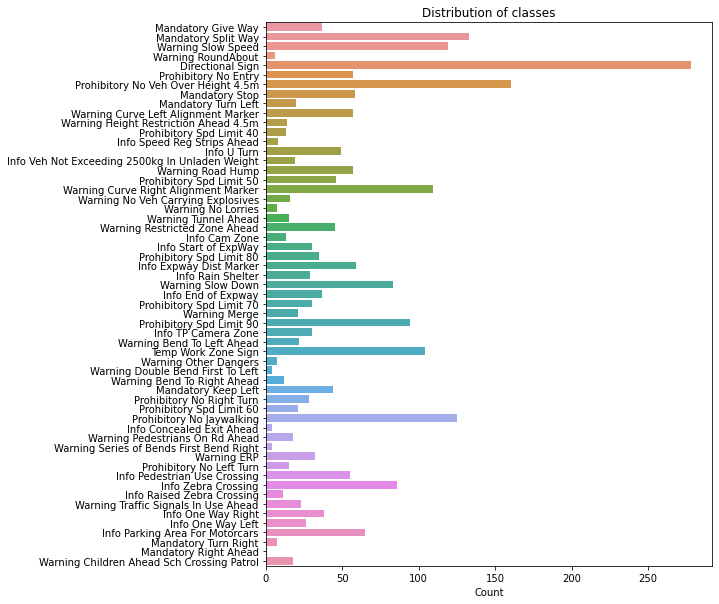

In [10]:
plt.figure(figsize=(8,10))
sns.countplot(data=traffic_signs_df, y='class')
plt.title('Distribution of classes')
plt.ylabel('')
plt.xlabel('Count')
plt.show()

Similar to the classification dataset, the object detection dataset has an imbalanced distribution of labels. Traffic signs like *Directional Sign* and *Prohibitory No Veh Over Height 4.5m* are present over 150 times, while signs like *Mandatory Turn Right* and *Info Speed Reg Strips Ahead* have less than 10 annotations available.

### Investigate distribution of traffic signs per image

Images might contain one or more traffic signs, so we calculate the distribution of classes occurring within every image:

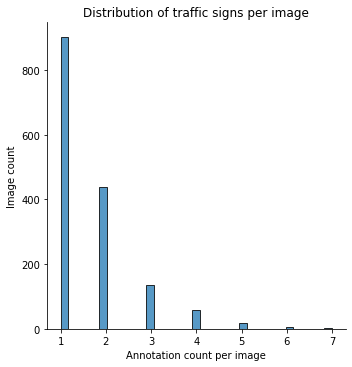

In [19]:
ts_agg = traffic_signs_df.groupby('filename').agg(class_count=('class','count'))
ts_agg.loc[:,'filename'] = ts_agg.index
ts_agg.reset_index(drop=True, inplace=True)


sns.displot(data=ts_agg, x='class_count')
plt.xlabel('Annotation count per image')
plt.ylabel('Image count')
plt.title('Distribution of traffic signs per image')
plt.show()

Above histogram shows that mode is 1, meaning that majority of images have only 1 traffic sign. The right skew indicates that a minority proportion of images have multiple annotations, with up to a maximum of 7 annotations in a few of the images.

### Sample images with multiple traffic signs

Traffic signs found: ['Prohibitory Spd Limit 90', 'Info Start of ExpWay', 'Info Cam Zone', 'Prohibitory Spd Limit 90']


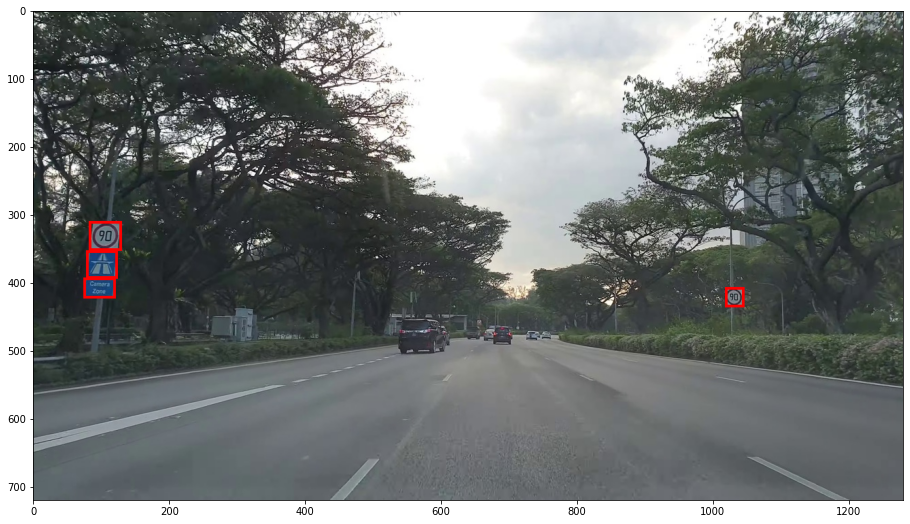

In [20]:
sample_img_filename = np.random.choice(ts_agg.loc[ts_agg.loc[:,'class_count']>=4,'filename'].values)
sample_img = Image.open(img_and_xml_dir_path+sample_img_filename)
draw = ImageDraw.Draw(sample_img)

# retrieve ground-truths
extracted_groundtruth_df = traffic_signs_df.loc[traffic_signs_df.loc[:,'filename']==sample_img_filename,:]

# plot out ground-truths (use width that is thinner than inference box!!)
for index, row in extracted_groundtruth_df.iterrows():
    # avoid printing ground-truth label, as image would get really messy
    draw.rectangle([(row['xmin'],row['ymin']),(row['xmax'], row['ymax'])], outline='red', width=4)
print('Traffic signs found: {}'.format(list(extracted_groundtruth_df.loc[:,'class'])))
plt.figure(figsize=(16,9))
plt.imshow(sample_img)
plt.show()

Above sampling of images indicate that it is possible for more than one traffic sign to occur within close proximity to each other. Furthermore, unlike vehicles, the traffic signs seem to occupy smaller area.

### Investigate distribution of image area proportion occupied by traffic sign

In [21]:
def calculate_area_proportion(row):
    total_img_area = row['width'] * row['height']
    traffic_sign_area = abs(row['xmax'] - row['xmin']) * abs(row['ymax'] - row['ymin'])
    return round(traffic_sign_area / total_img_area * 100, 2)

In [22]:
traffic_signs_df.loc[:,'pct_area'] = traffic_signs_df.apply(lambda x: calculate_area_proportion(x), axis=1)
traffic_signs_df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax,sign_type,xmid,ymid,ymid_reversed,pct_area
0,24_s_000060.jpg,1280,720,Mandatory Give Way,799,354,845,401,Mandatory,822,378,342,0.23
1,24_s_000090.jpg,1280,720,Mandatory Give Way,923,328,983,383,Mandatory,953,356,364,0.36
2,24_s_000120.jpg,1280,720,Mandatory Give Way,1149,268,1238,344,Mandatory,1194,306,414,0.73
3,24_s_000420.jpg,1280,720,Mandatory Split Way,466,506,507,546,Mandatory,486,526,194,0.18
4,24_s_000450.jpg,1280,720,Mandatory Split Way,223,496,282,550,Mandatory,252,523,197,0.35


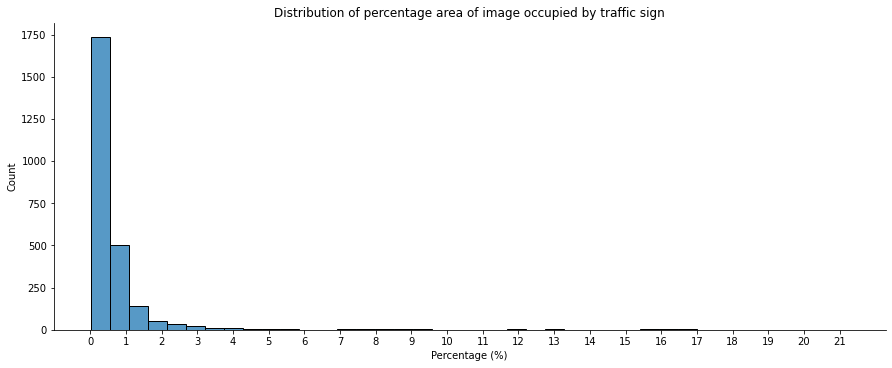

In [23]:
sns.displot(data=traffic_signs_df, x='pct_area', bins=40, height=5, aspect=2.5)
plt.xticks(range(0, math.ceil(traffic_signs_df.loc[:,'pct_area'].max()), 1))
plt.xlabel('Percentage (%)')
plt.title('Distribution of percentage area of image occupied by traffic sign')
plt.show()

The above histogram reveals that majority of traffic signs occupy only up to 0.5% of the area of a given image, with a severe right-skew indicating that a very small proportion of traffic signs may occupy up to 21% of the area of an image. Such a low signal-to-noise ratio is typical of small object detection, where the target class tends to get lost in background clutter.

### Investigate traffic sign positions in frame via scatterplot

In [24]:
traffic_signs_df.loc[:,'sign_type'] = traffic_signs_df.loc[:,'class'].apply(lambda x: x.split(' ')[0])
traffic_signs_df.loc[:,'xmid'] = traffic_signs_df.apply(lambda row: round(mean([row['xmin'], row['xmax']])), axis=1)
traffic_signs_df.loc[:,'ymid'] = traffic_signs_df.apply(lambda row: round(mean([row['ymin'], row['ymax']])), axis=1)
traffic_signs_df.loc[:,'ymid_reversed'] = traffic_signs_df.apply(lambda row: row['height'] - row['ymid'], axis=1)
traffic_signs_df.sample(5)

,filename,width,height,class,xmin,ymin,xmax,ymax,sign_type,xmid,ymid,ymid_reversed,pct_area
1540,31_s_022490.jpg,1280,720,Prohibitory No Jaywalking,1156,349,1224,407,Prohibitory,1190,378,342,0.43
1909,33_s_013690.jpg,1280,720,Warning ERP,210,318,279,387,Warning,244,352,368,0.52
837,26_s_012280.jpg,1280,720,Warning Slow Speed,132,330,190,371,Warning,161,350,370,0.26
2112,34_s_001420.jpg,1280,720,Temp Work Zone Sign,28,303,119,389,Temp,74,346,374,0.85
2408,35_s_051160.jpg,1280,720,Warning Tunnel Ahead,1088,401,1158,468,Warning,1123,434,286,0.51


In [40]:
def scatterplot_for_traffic_sign(sign_type, color, name):
    plt.figure(figsize=(16, 9))
    plt.title('Scatterplot of {} positions by percentage-area'.format(name), fontsize=20)
    g = sns.scatterplot(
        data=traffic_signs_df.loc[traffic_signs_df.loc[:,'sign_type']==sign_type,:], x='xmid', y='ymid_reversed', size='pct_area', sizes=(40, 400), color=color,
        marker='o', alpha=0.6) #height=10, aspect=2.0

    plt.xticks(range(0, 1280, 256))
    plt.xlim([0, 1280])
    plt.yticks(range(0, 720, 240))
    plt.ylim([0, 720])
    plt.margins(x=0, y=0) # force removal of white space
    plt.grid(b=True, which='major', color='gray', linestyle='-', linewidth=0.5)
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')
    plt.show()

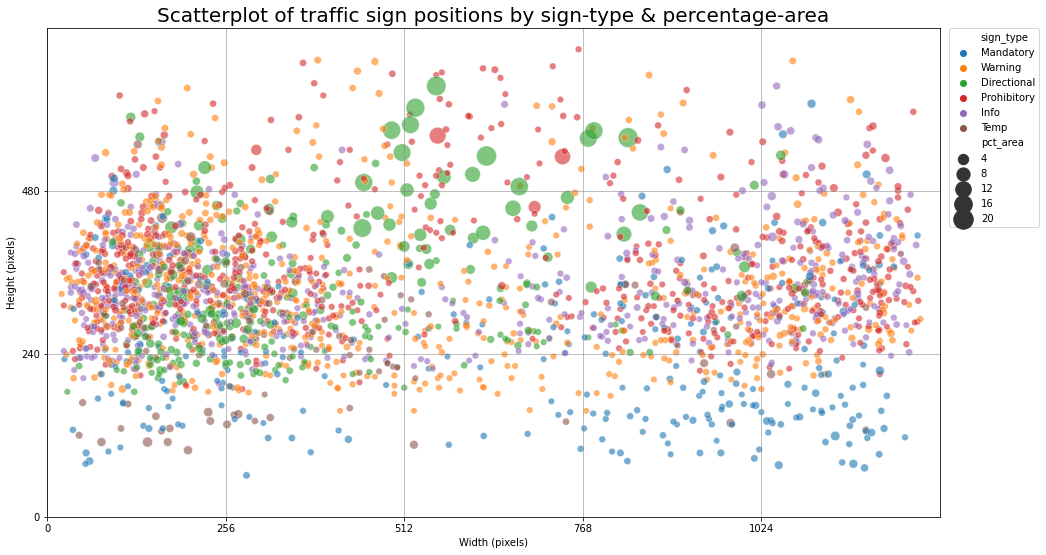

In [42]:
plt.figure(figsize=(16, 9))
plt.title('Scatterplot of traffic sign positions by sign-type & percentage-area', fontsize=20)
g = sns.scatterplot(
    data=traffic_signs_df, x='xmid', y='ymid_reversed', hue='sign_type', size='pct_area', sizes=(40, 400), 
    marker='o', alpha=0.6) #height=10, aspect=2.0

plt.xticks(range(0, 1280, 256))
plt.xlim([0, 1280])
plt.yticks(range(0, 720, 240))
plt.ylim([0, 720])
plt.margins(x=0, y=0) # force removal of white space
plt.grid(b=True, which='major', color='gray', linestyle='-', linewidth=0.5)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.show()

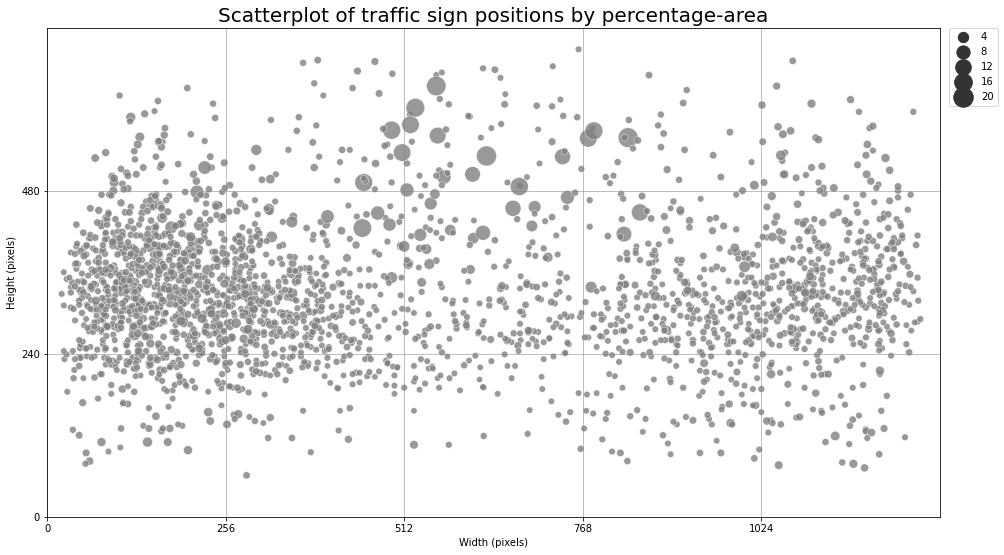

In [56]:
plt.figure(figsize=(16, 9))
plt.title('Scatterplot of traffic sign positions by percentage-area', fontsize=20)
g = sns.scatterplot(
    data=traffic_signs_df, x='xmid', y='ymid_reversed', size='pct_area', sizes=(40, 400), color='gray',
    marker='o', alpha=0.8) #height=10, aspect=2.0

plt.xticks(range(0, 1280, 256))
plt.xlim([0, 1280])
plt.yticks(range(0, 720, 240))
plt.ylim([0, 720])
plt.margins(x=0, y=0) # force removal of white space
plt.grid(b=True, which='major', color='gray', linestyle='-', linewidth=0.5)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.show()

Traffic signs occur most frequently in the left-most and right-most mid-section segments of a given frame, logically because most traffic signs are likely located at either side of the road (typically around 2m height on top of a metal pole).

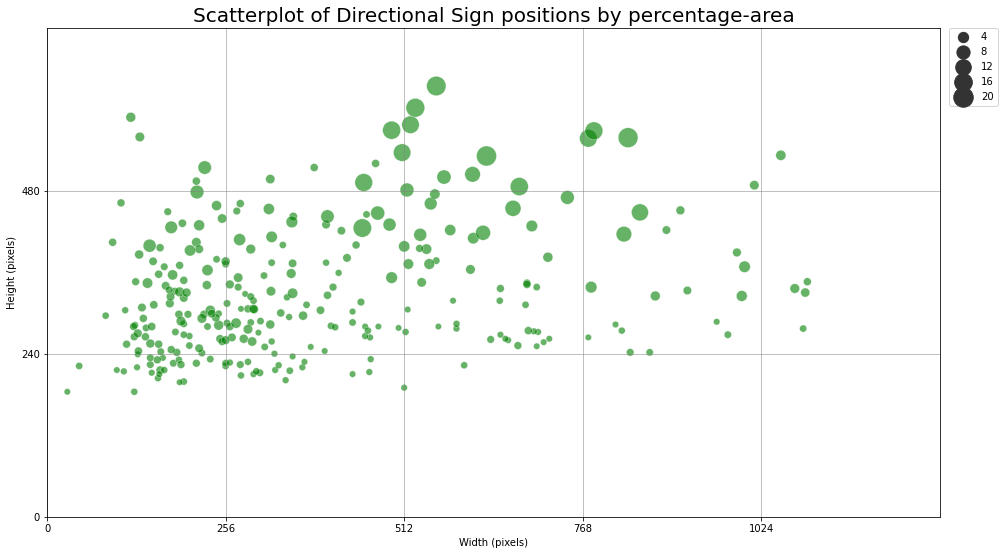

In [41]:
scatterplot_for_traffic_sign(sign_type='Directional', color='green', name='Directional Sign')

Big green markers on the top middle segment indicates that most directional signs are located overhead, especially those on expressways. Otherwise, most directional signs are found on left side of road.

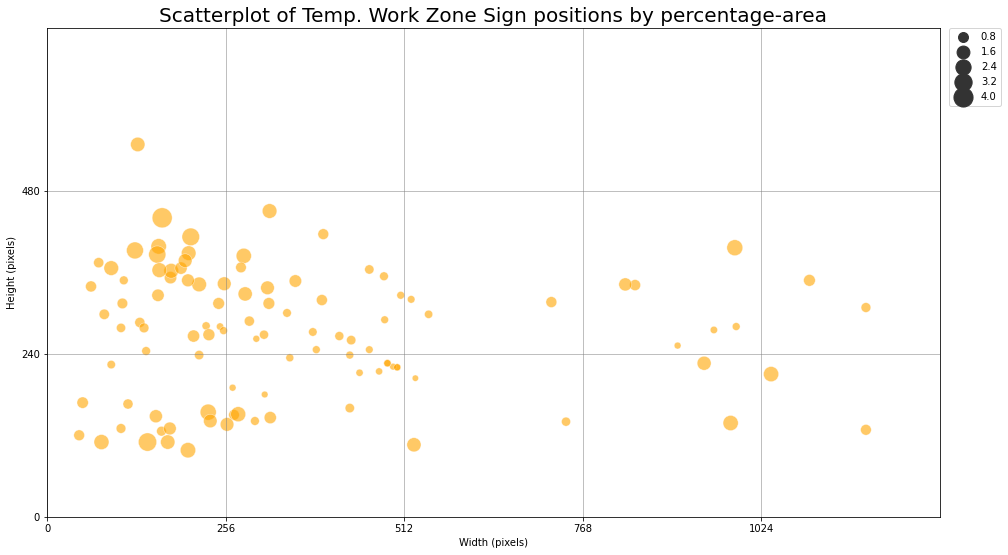

In [43]:
scatterplot_for_traffic_sign(sign_type='Temp', color='orange', name='Temp. Work Zone Sign')

Temporary work zone signs tend to appear on the left side of the road, usually position close to ground, or mounted on pole. They tend to be larger than most mandatory, information, prohibitory and warning signs.

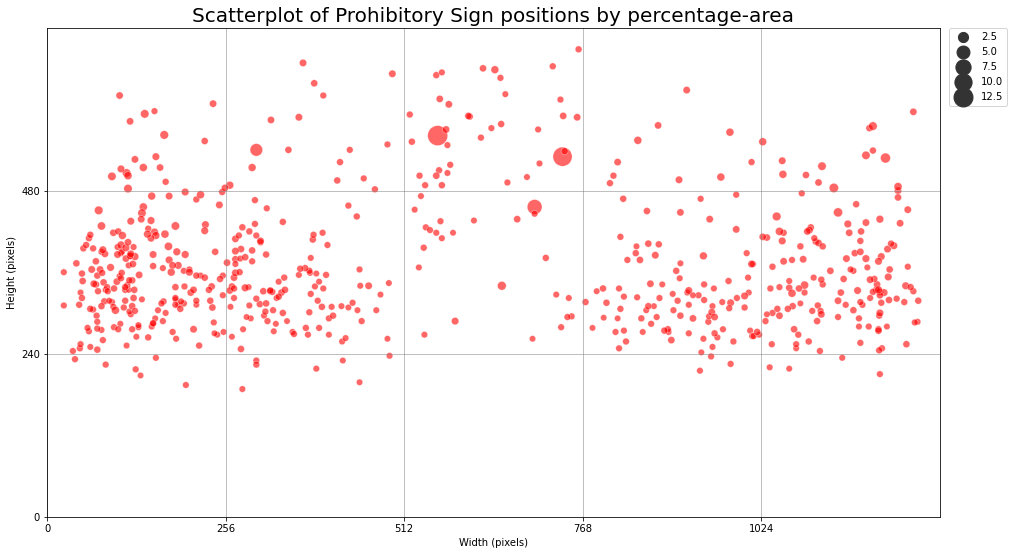

In [44]:
scatterplot_for_traffic_sign(sign_type='Prohibitory', color='red', name='Prohibitory Sign')

Prohibitory signs typically appear on both sides of a road, with slightly higher incidence rate on the left.

Red markers occurring on top middle segment are mostly referring to the *Prohibitory No Vehicle Over Height 4.5m* signs that warn motorists of height limits at overhead bridges.

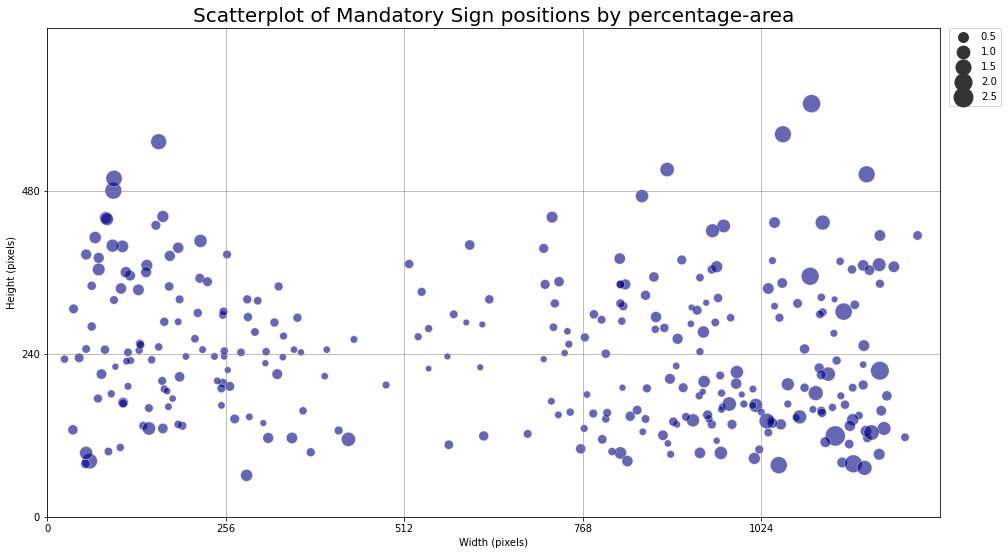

In [45]:
scatterplot_for_traffic_sign(sign_type='Mandatory', color='navy', name='Mandatory Sign')

Mandatory signs have a higher incidence rate in the lower-third segment of both sides of the frame (i.e. mounted close to ground level). Furthermore, it is possibly the only class of signs where there is a higher incidence rate of it on the right side of the frame, mostly owing to the occurrence of *MANDATORY_SPLIT_WAY* and *MANDATORY_KEEP_LEFT* signs appearing at gound level to provide safe demarcation of road areas for 2-way traffic.

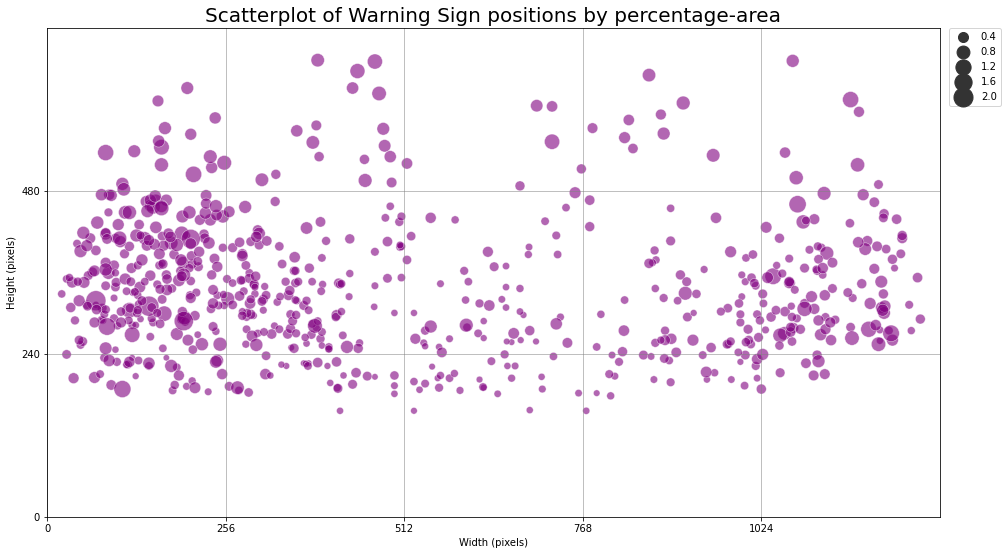

In [51]:
scatterplot_for_traffic_sign(sign_type='Warning', color='purple', name='Warning Sign')

Share nearly the same traits as Prohibitory signs, with more Warning signs appearing on left side of road, and almost none being mounted close to ground level.

## Pre-processing

In this section, we decide on the set of traffic signs that we intend to perform object detection training on. As shown in *Exploratory Data Analysis*, there is class imbalance in the dataset, and performing training on classes with few observations would increase the risk of overfitting during training with a high number of iterations. As such, we would pick only traffic signs where we have **at least 100 observations**. This would ensure that there is still sufficient volume for train/test/validation split.

Process would be as follows:

<img src='./Images/object_detection_preprocessing.png' />

### Extract classes with at least 100 observations

In [183]:
class_agg = traffic_signs_df.groupby('class').agg(file_count=('filename','count'))
class_agg.loc[:,'class'] = class_agg.index
class_agg.reset_index(drop=True, inplace=True)
class_agg = class_agg.loc[:,['class','file_count']]
class_agg_filtered = class_agg.loc[class_agg.loc[:,'file_count']>=100,:]
print(class_agg_filtered.shape)
class_agg_filtered

(7, 2)


,class,file_count
0,Directional Sign,278
20,Mandatory Split Way,133
25,Prohibitory No Jaywalking,125
28,Prohibitory No Veh Over Height 4.5m,160
35,Temp Work Zone Sign,104
40,Warning Curve Right Alignment Marker,109
54,Warning Slow Speed,119


### Build finalized dictionary of classes

In [187]:
finalized_classes = list(class_agg_filtered.loc[:,'class'])
finalized_classes

['Directional Sign',
 'Mandatory Split Way',
 'Prohibitory No Jaywalking',
 'Prohibitory No Veh Over Height 4.5m',
 'Temp Work Zone Sign',
 'Warning Curve Right Alignment Marker',
 'Warning Slow Speed']

In [188]:
finalized_classes_dict = {l: i for i,l in enumerate(finalized_classes, 1)}
finalized_classes_dict

{'Directional Sign': 1,
 'Mandatory Split Way': 2,
 'Prohibitory No Jaywalking': 3,
 'Prohibitory No Veh Over Height 4.5m': 4,
 'Temp Work Zone Sign': 5,
 'Warning Curve Right Alignment Marker': 6,
 'Warning Slow Speed': 7}

### Extract annotation records from `traffic_signs_df` that contain classes in the finalised list

In [189]:
traffic_signs_filtered = traffic_signs_df.loc[(traffic_signs_df.loc[:,'class'].isin(finalized_labels)), :]
#print(ts_filtered.shape)
print(traffic_signs_filtered.loc[:,'filename'].nunique())

767


### One-hot encode the classes

In [190]:
# perform one-hot encoding via pivot table aggregation
traffic_signs_pivot_table = traffic_signs_filtered.loc[:, ['filename','class']] \
                                .pivot_table(index=['filename'], columns=['class'], aggfunc=[len], fill_value=0)

# inspect shape of pivot table. It should have the same number of rows as
# the number of image files, with 7 rows corresponding to the 7 classes,
# while the filename remains as an index
print(traffic_signs_pivot_table.shape)

# simply the column names (i.e. avoid the tuple representation for column names)
traffic_signs_pivot_table.columns = [c[1] for c in traffic_signs_pivot_table.columns]

# get list of class columns (to facilitate re-arrangement later)
class_columns = list(traffic_signs_pivot_table.columns)

# convert filename index into a regular column
traffic_signs_pivot_table.loc[:,'filename'] = traffic_signs_pivot_table.index

# reset index to regular running numbers
traffic_signs_pivot_table.reset_index(drop=True, inplace=True)

# re-arrange columns so that filename is 1st column
traffic_signs_pivot_table = traffic_signs_pivot_table.loc[:,['filename']+class_columns]

# inspect 1st 10 rows
traffic_signs_pivot_table.head(10)

(767, 7)


,filename,Directional Sign,Mandatory Split Way,Prohibitory No Jaywalking,Prohibitory No Veh Over Height 4.5m,Temp Work Zone Sign,Warning Curve Right Alignment Marker,Warning Slow Speed
0,24_s_000420.jpg,0,1,0,0,0,0,0
1,24_s_000450.jpg,0,1,0,0,0,0,0
2,24_s_000630.jpg,0,1,0,0,0,0,0
3,24_s_000670.jpg,0,1,0,0,0,0,0
4,24_s_000690.jpg,0,1,0,0,0,0,0
5,24_s_001420.jpg,1,0,0,0,0,0,1
6,24_s_001440.jpg,1,0,0,0,0,0,1
7,24_s_001450.jpg,0,0,0,0,0,0,1
8,24_s_001630.jpg,1,0,0,0,0,0,0
9,24_s_001650.jpg,1,0,0,0,0,0,0


### Perform X/y split of inputs and categorical targets

Inputs are simply the filename, while the one-hot encoded classes become the targets

In [194]:
X = traffic_signs_pivot_table.loc[:,['filename']]
y = traffic_signs_pivot_table.loc[:,[c for c in traffic_signs_pivot_table.columns if c != 'filename']]

In [195]:
y.describe()

,Directional Sign,Mandatory Split Way,Prohibitory No Jaywalking,Prohibitory No Veh Over Height 4.5m,Temp Work Zone Sign,Warning Curve Right Alignment Marker,Warning Slow Speed
count,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000
mean,0.362451,0.173403,0.162973,0.208605,0.135593,0.142112,0.155150
std,0.522645,0.382273,0.400112,0.493592,0.411801,0.525474,0.362284
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,2.000000,2.000000,3.000000,4.000000,4.000000,1.000000


Above statistics has revealed that the one-hot-encoded columns have values other than 1, simply because *len* was the aggregation function in the pivot-table operation. That would mean that some images have multiple traffic signs of the same classes. 

We want these columns to only indicate presence (1) or absence (0) of a class, so we use a lambda function to convert any non-zero value into 1.

In [196]:
for col in class_columns:
    y.loc[:,col] = y.loc[:,col].apply(lambda x: 0 if x==0 else 1)
    
y.describe()

,Directional Sign,Mandatory Split Way,Prohibitory No Jaywalking,Prohibitory No Veh Over Height 4.5m,Temp Work Zone Sign,Warning Curve Right Alignment Marker,Warning Slow Speed
count,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000
mean,0.341591,0.172099,0.151239,0.170795,0.114733,0.082138,0.155150
std,0.474553,0.377713,0.358515,0.376576,0.318907,0.274754,0.362284
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Perform train/test/validation split on dataset

We use the *IterativeStratification* method in *skmultilearn* package to handle the multi-label aspect of the dataset.

The split will be as follows:

| Subset | Proportion |
|--------|------------|
| Train | 70% |
| Validation | 20% |
| Test | 10% |
| Total | 100% |

In [200]:
stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[0.3, 0.7])
train_indexes, test_validation_indexes = next(stratifier.split(X, y))
X_train, y_train = X.loc[train_indexes], y.loc[train_indexes]
X_test_validation, y_test_validation = X.loc[test_validation_indexes], y.loc[test_validation_indexes]

In [202]:
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test_validation shape: {}'.format(X_test_validation.shape))
print('y_test_validation shape: {}'.format(y_test_validation.shape))

X_train shape: (535, 1)
y_train shape: (535, 7)
X_test_validation shape: (232, 1)
y_test_validation shape: (232, 7)


In [203]:
X_test_validation.reset_index(inplace=True)
y_test_validation.reset_index(inplace=True)
stratifier2 = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[0.67, 0.33])
test_indexes, validation_indexes = next(stratifier2.split(X_test_validation, y_test_validation))
#print(test_indexes)
#print(validation_indexes)
X_test, y_test = X_test_validation.loc[test_indexes], X_test_validation.loc[test_indexes]
X_validation, y_validation = X_test_validation.loc[validation_indexes], X_test_validation.loc[validation_indexes]

In [204]:
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))
print('X_validation shape: {}'.format(X_validation.shape))
print('y_validation shape: {}'.format(y_validation.shape))
#print(type(X_train))
#print(test_indexes)
#print(validation_indexes)
#print(type(X))
#print(type(X_test_validation))

X_test shape: (76, 2)
y_test shape: (76, 2)
X_validation shape: (156, 2)
y_validation shape: (156, 2)


### Create individual folders to hold images and annotations

#### Helper function to perform data transfer

In [222]:
def process_input_data(source_dir, dest_dir, img_filename_list, permitted_labels_list):
    #for img_filename in img_filename_list:
    #source_path = os.path.join(source_dir, img_filename_list[0])
    #dest_path = os.path.join(dest_dir, img_filename_list[0])
    #print(source_path)
    #print(dest_path)
    print('          Number of images: {}'.format(len(img_filename_list)))
    print('Number of permitted labels: {}'.format(len(permitted_labels_list)))
    print('          Source directory: {}'.format(source_dir))
    print('     Destination Directory: {}'.format(dest_dir))
    for img_filename in img_filename_list:
        source_img_path = os.path.join(source_dir, img_filename)
        dest_img_path = os.path.join(dest_dir, img_filename)
        
        copyfile(src=source_img_path, dst=dest_img_path)
        
        source_xml_path = os.path.join(source_dir, img_filename.replace('.jpg','.xml'))
        dest_xml_path = os.path.join(dest_dir, img_filename.replace('.jpg','.xml'))
        tree = ET.parse(source_xml_path)
        object_list = tree.findall('object')
        for element in object_list:
            if element.find('name').text not in permitted_labels_list:
                tree.getroot().remove(element)
        tree.write(dest_xml_path)
    print('Completed')

#### Transfer files for training

In [211]:
train_img_dir_path

'E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/'

In [212]:
process_input_data(
    source_dir=img_and_xml_dir_path, 
    dest_dir=train_img_dir_path, 
    img_filename_list=list(X_train.loc[:,'filename']), 
    permitted_labels_list=finalized_classes)

Number of images: 535
Number of permitted labels: 7
Completed


#### Transfer files for testing

In [223]:
test_img_dir_path

'E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TEST/'

In [224]:
process_input_data(
    source_dir=img_and_xml_dir_path, 
    dest_dir=test_img_dir_path, 
    img_filename_list=list(X_test.loc[:,'filename']), 
    permitted_labels_list=finalized_classes)

          Number of images: 76
Number of permitted labels: 7
          Source directory: E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION/
     Destination Directory: E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TEST/
Completed


#### Transfer files for validation

In [225]:
validation_img_dir_path

'E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_VALIDATION/'

In [226]:
process_input_data(
    source_dir=img_and_xml_dir_path, 
    dest_dir=validation_img_dir_path, 
    img_filename_list=list(X_validation.loc[:,'filename']), 
    permitted_labels_list=finalized_classes)

          Number of images: 156
Number of permitted labels: 7
          Source directory: E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION/
     Destination Directory: E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_VALIDATION/
Completed


### Convert XML annotations into a CSV file

#### Convert train annotations into CSV file

In [220]:
train_df = annotation_xml_to_dataframe(train_img_dir_path)
train_csv_path = tfrecord_base_dir_path + 'train.csv'
train_df.to_csv(train_csv_path, index=None)
print(train_csv_path)
print(train_df.shape)

E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/train.csv
(717, 8)


#### Convert test annotations into CSV file

In [227]:
test_df = annotation_xml_to_dataframe(test_img_dir_path)
test_csv_path = tfrecord_base_dir_path + 'test.csv'
test_df.to_csv(test_csv_path, index=None)
print(test_csv_path)
print(test_df.shape)

E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/test.csv
(105, 8)


#### Convert validation annotations into CSV file

In [229]:
validation_df = annotation_xml_to_dataframe(validation_img_dir_path)
validation_csv_path = tfrecord_base_dir_path + 'validation.csv'
validation_df.to_csv(validation_csv_path, index=None)
print(validation_csv_path)
print(validation_df.shape)

E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/validation.csv
(206, 8)


### Create TFRecords for train/test/validation data

#### Import all necessary libaries

In [248]:
import io
import tensorflow as tf

# for TFRecord generation
from object_detection.utils import dataset_util
import collections

# for label manifest generation
from object_detection.protos.string_int_label_map_pb2 import StringIntLabelMap, StringIntLabelMapItem
from google.protobuf import text_format

#### Define helper functions for facilitating TFRecord conversion

In [232]:
# converts class string label into an integer via looking up the class dictionary
def class_text_to_int(row_label, label_dict):
    if row_label in label_dict.keys():
        return label_dict[row_label]
    else:
        print('ERROR CLASS NOT FOUND FOR {}'.format(row_label))
        None

In [233]:
# creates a tuple holding filename and a group of object records associated with the respective filename
def split_group(df, group):
    data = collections.namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

In [234]:
# creates an Example binary using the provided group and class dictionary
def create_tf_example(group, path, label_dict):
    print(os.path.join(path, '{}'.format(group.filename)))
    with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class'], label_dict))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

In [242]:
# creates a TFRecord file containing all the Examples that form the binary representation of an image with annotation data
def generate_tfrecord_datafile(tfrecord_output_path, img_dir_path, annotation_csv_path, label_dict):
    print('tfrecord_output_path: {}'.format(tfrecord_output_path))
    print('img_dir_path: {}'.format(img_dir_path))
    print('annotation_csv_path: {}'.format(annotation_csv_path))
    writer = tf.compat.v1.python_io.TFRecordWriter(tfrecord_output_path)
    examples = pd.read_csv(annotation_csv_path)
    grouped = split_group(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, img_dir_path, label_dict)
        writer.write(tf_example.SerializeToString())

    writer.close()
    print('Successfully created the TFRecords: {}'.format(tfrecord_output_path))

In [238]:
finalized_classes_dict

{'Directional Sign': 1,
 'Mandatory Split Way': 2,
 'Prohibitory No Jaywalking': 3,
 'Prohibitory No Veh Over Height 4.5m': 4,
 'Temp Work Zone Sign': 5,
 'Warning Curve Right Alignment Marker': 6,
 'Warning Slow Speed': 7}

#### Generate TFRecord for train data

In [237]:
train_dir_path+'train.record'

'E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/train/train.record'

In [243]:
generate_tfrecord_datafile(
    tfrecord_output_path=train_dir_path+'train.record', 
    img_dir_path=train_img_dir_path,
    annotation_csv_path=train_csv_path,
    label_dict=finalized_classes_dict)

tfrecord_output_path: E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/train/train.record
img_dir_path: E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/
annotation_csv_path: E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/train.csv
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/24_s_000450.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/24_s_000670.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/24_s_001420.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/24_s_001650.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/24_s_001830.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/24_s_002200.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/24_s_002930.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/24_s_002970.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/24_s_003670.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/24_s_003990.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/24_s_005180.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/24_s_005290.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/24_s_005710.jpg
E:/SG_TRAFFIC_SIGNS

E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/27_s_031850.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/27_s_032730.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/28_s_000530.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/28_s_000680.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/28_s_002180.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/28_s_002240.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/28_s_002290.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/28_s_003550.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/28_s_003910.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/28_s_003940.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/28_s_005440.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/28_s_007000.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/28_s_009210.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/28_s_009720.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/28_s_010710.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/28_s_011030.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/28_s_012030.j

E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/33_s_024420.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/33_s_025560.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/33_s_025650.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/33_s_029850.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/33_s_030220.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/33_s_030230.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/33_s_030580.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/33_s_030840.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/33_s_031450.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/33_s_033630.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/33_s_034200.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/33_s_034280.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/33_s_034720.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/33_s_035020.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/33_s_035050.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/33_s_035070.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/33_s_035940.j

E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/35_s_095240.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/35_s_095420.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/35_s_096310.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/35_s_097110.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/35_s_103650.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/35_s_105160.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/35_s_105360.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/35_s_106030.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/35_s_106050.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/35_s_141920.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/35_s_142440.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/35_s_142800.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/35_s_142810.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/35_s_142950.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/35_s_143340.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TRAIN/35_s_143560.jpg
Successfully created the TFRecords: E:/SG_TRAFFIC_SIGNS_

#### Generate TFRecord for test data

In [244]:
test_dir_path+'test.record'

'E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/test/test.record'

In [245]:
generate_tfrecord_datafile(
    tfrecord_output_path=test_dir_path+'test.record', 
    img_dir_path=test_img_dir_path,
    annotation_csv_path=test_csv_path,
    label_dict=finalized_classes_dict)

tfrecord_output_path: E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/test/test.record
img_dir_path: E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TEST/
annotation_csv_path: E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/test.csv
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TEST/24_s_000630.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TEST/24_s_001450.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TEST/24_s_001630.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TEST/24_s_002230.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TEST/24_s_002950.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TEST/24_s_003640.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TEST/24_s_005730.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TEST/24_s_007370.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TEST/24_s_008280.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TEST/24_s_008490.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TEST/24_s_010370.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TEST/24_s_029970.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TEST/24_s_030470.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION

#### Generate TFRecord for validation data

In [246]:
validation_dir_path+'validation.record'

'E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/validation/validation.record'

In [247]:
generate_tfrecord_datafile(
    tfrecord_output_path=validation_dir_path+'validation.record', 
    img_dir_path=validation_img_dir_path,
    annotation_csv_path=validation_csv_path,
    label_dict=finalized_classes_dict)

tfrecord_output_path: E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/validation/validation.record
img_dir_path: E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_VALIDATION/
annotation_csv_path: E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/validation.csv
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_VALIDATION/24_s_000420.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_VALIDATION/24_s_000690.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_VALIDATION/24_s_001440.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_VALIDATION/24_s_001810.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_VALIDATION/24_s_004010.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_VALIDATION/24_s_007350.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_VALIDATION/24_s_007400.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_VALIDATION/24_s_007550.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_VALIDATION/24_s_008150.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_VALIDATION/24_s_008400.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_VALIDATION/24_s_008930.jpg
E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_VALIDATION/24_s_010420.jp

Successfully created the TFRecords: E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/validation/validation.record


#### Generate label manifest from class dictionary

In [249]:
def convert_classes(label_dict):
    msg = StringIntLabelMap()
    for k in sorted(list(label_dict.keys())):
        msg.item.append(StringIntLabelMapItem(id=label_dict[k], name=k))
    #for id, name in enumerate(classes, start=start):
    #    msg.item.append(StringIntLabelMapItem(id=id, name=name))

    text = str(text_format.MessageToBytes(msg, as_utf8=True), 'utf-8')
    return text

In [251]:
txt = convert_classes(finalized_classes_dict)
print(txt)
with open(train_dir_path+'label_map.pbtxt', 'w') as f:
    f.write(txt)
with open(test_dir_path+'label_map.pbtxt', 'w') as f:
    f.write(txt)
with open(validation_dir_path+'label_map.pbtxt', 'w') as f:
    f.write(txt)

item {
  name: "Directional Sign"
  id: 1
}
item {
  name: "Mandatory Split Way"
  id: 2
}
item {
  name: "Prohibitory No Jaywalking"
  id: 3
}
item {
  name: "Prohibitory No Veh Over Height 4.5m"
  id: 4
}
item {
  name: "Temp Work Zone Sign"
  id: 5
}
item {
  name: "Warning Curve Right Alignment Marker"
  id: 6
}
item {
  name: "Warning Slow Speed"
  id: 7
}



### Put all TFRecords and CSV files into zip archive

In [262]:
#import os
import zipfile    

def zipit(folders, files, zip_filename):
    zip_file = zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED)

    for folder in folders:
        print('Processing folder: {}'.format(folder))
        for dirpath, dirnames, filenames in os.walk(folder):
            for filename in filenames:
                zip_file.write(
                    os.path.join(dirpath, filename),
                    os.path.relpath(os.path.join(dirpath, filename), os.path.join(folders[0], '../..')))
    
    for f in files:
        print('Processing file: {}'.format(f))
        zip_file.write(f)
    
    zip_file.close()

In [263]:
folders = [
    train_dir_path,
    test_dir_path,
    validation_dir_path
]

files = [
    train_csv_path,
    test_csv_path,
    validation_csv_path
]

zipit(folders, files, tfrecord_base_dir_path+'sg-traffic-signs.zip')

Processing folder: E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/train/
Processing folder: E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/test/
Processing folder: E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/validation/
Processing file: E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/train.csv
Processing file: E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/test.csv
Processing file: E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/validation.csv


## Preparation of project assets on Google Drive for Colab-based Model Training

Training of the object detection model would be performed on Google Colab environment, so as to take advantage of the GPU-accelerated environment for faster training process.

We would also be selecting the **SSD MobileNet V2 FPNLite 640x640** model from [Tensorflow Hub](https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1) (also available on Tensorflow 2 Model Zoo [github page](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md)). It is a single-shot multibox detector that is designed to effectively maximise detection accuracy while being relatively light on resource requirements, making it suitable for mobile applications.

The setup process is as follows:

<img src='./Images/od_training_asset_prep_process.png' />

### Inspection of existing assets in `SSD MobileNet V2 FPNLite 640x640` pre-trained model folder

```
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/ <- Root folder of the downloaded pre-trained model
|
├─checkpoint/                                  <- Sub-folder containing checkpoint data for transfer learning
|   ├─checkpoint
|   ├─ckpt-0.data-00000-of-00001
|   └─ckpt-0.index
|
├─saved_model/                                 <- Contains frozen inference graph
|   ├─variables/
|   |   ├─variables.data-00000-of-00001
|   |   └─variables.index
|   └─saved_model.pb
|
└─pipeline.config                              <- Configuration for model training and hyper-parameter tuning

```

### Updating of `pipeline.config` file

The `pipeline.config` file in `ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8` folder must be updated to reflect the settings meant for training the model on Google Colab environment:

1. *num_classes* in **ssd** segment updated from 90 to 7, to reflect the number of classes we are training.


2. *batch_size* in **train_config** segment updated from 128 to 8, a suitable size for Colab training (with T4/P100 GPU)


3. *random_horizontal_flip* and *random_crop_image* data-augmentations in **train_config** segment replaced with *random_adjust_contrast* and *random_adjust_brightness* (associated parameters to be updated too).


4. *fine_tune_checkpoint* in **train_config** segment updated from "PATH_TO_BE_CONFIGURED" to "/content/drive/MyDrive/sg_traffic_signs/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-0", as this path would be made available after mounting Google Drive on Google Colab session during training.


5. *num_steps* in **train_config** segment updated from 50000 to 12000.


6. *fine_tune_checkpoint_type* in **train_config** segment updated from classification to detection, as we are training for object detection.


7. *label_map_path* in **train_input_reader** segment updated from "PATH_TO_BE_CONFIGURED" to "/content/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/train/label_map.pbtxt", which is the label manifest.


8. *input_path* in **tf_record_input_reader** sub-segment of **train_input_reader** segment updated from "PATH_TO_BE_CONFIGURED" to "/content/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/train/train.record", to reflect location of training TFRecord file when sg-traffic-signs.zip is extracted to Colab environment.


9. *label_map_path* in **eval_input_reader** segment updated from "PATH_TO_BE_CONFIGURED" to "/content/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/validation/label_map.pbtxt", which is the label manifest (same content as the one in step-7)


10. *input_path* in **tf_record_input_reader** sub-segment of **eval_input_reader** segment updated from "PATH_TO_BE_CONFIGURED" to "/content/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/validation/validation.record", to reflect location of validation TFRecord file when sg-traffic-signs.zip is extracted to Colab environment.

### Creating `evaluation_pipeline.config`

1) Make a copy of *pipeline.config* file, and rename it to *evaluation_pipeline.config*


2) *input_path* in **tf_record_input_reader** sub-segment of **eval_input_reader** segment in *evaluation_pipeline.config* updated from "/content/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/validation/validation.record" to "/content/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_DATA/test/test.record", to reflect location of test TFRecord file when sg-traffic-signs.zip is extracted to Colab environment.

The above script would be used for evaluation of the trained model's accuracy, after training has been completed. It would utilised the test dataset, which holds 10% of the overall dataset that is used for object detection training.

### Create new sub-folders

Create the following new sub-folders in `ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8`:

| Sub-folder | Purpose |
|-|-|
| evaluation | To hold evaluation results when model is evaluated by script at end of training on Colab |
| exported_model | To hold the exported model after end of training in Colab |
| predictions | To hold test images with inferences for visual evaluation |
| traing | To hold intermediate checkpoints and TF-event information during the actual training process |

### Inspect folder layout of `ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8`

```
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/ <- Root folder of the downloaded pre-trained model
|
├─checkpoint/                                  <- Sub-folder containing checkpoint data for transfer learning
|   ├─checkpoint
|   ├─ckpt-0.data-00000-of-00001
|   └─ckpt-0.index
|
├─evaluation/                                  <- To hold evaluation results
|
├─exported_model/                              <- To hold the exported model that is fully trained
|
├─predictions/                                 <- To hold test images with inferences included
|
├─saved_model/                                 <- Contains frozen inference graph of current pre-trained model
|   ├─variables/
|   |   ├─variables.data-00000-of-00001
|   |   └─variables.index
|   └─saved_model.pb
|
├─training/                                    <- To hold intermediate checkpoints and TF-events generated during training
|
├─evaluation_pipeline.config                   <- To evaluate accuracy score of trained model with test dataset
|
├─label_map.pbtxt                              <- Extra label manifest (optional, same as those in sg-traffic-signs.zip)
|
└─pipeline.config                              <- Configuration for model training and hyper-parameter tuning
```

### Set up project assets in Google Drive

In [2]:
print('Location of test images: {}'.format(test_img_dir_path))

Location of test images: E:/SG_TRAFFIC_SIGNS_OBJECT_DETECTION_TEST/


1. Create new folder `sg_traffic_signs` in the root directory of Google Drive.


2. Upload `ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8` folder from local computer into `sg_traffic_signs` folder in Google Drive.


3. Upload `sg-traffic-signs.zip` from local computer into `sg_traffic_signs` folder in Google Drive.


4. Upload the folder containing the test images (as well as XML annotations) into `sg_traffic_signs` folder in Google Drive, and rename it to `test`.


The final setup in Google Drive should be as follows:

<img src='./Images/google_drive_sg_traffic_signs_setup.jpg' />

And the `ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8` folder in Google Drive should be as follows:

<img src='./Images/google_drive_sg_traffic_signs_setup_02.jpg' />

### Model Training on Colab

Proceed with model training using the `Colab Notebook for Singapore Road Traffic Signs Detection - Model Training via Tensorflow 2 Object Detection API (v2).ipynb` notebook on Google Colab environment.

Note:

At the end of the Colab Notebook, **predictions.zip** and **exported_model.zip** will be created in the `ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8` folder. 

**predictions.zip** contains *test* set images with inferences and ground-truth boxes drawn on them for visual comparison.

**exported_model.zip** contains the inference graph and checkpoint which can be restored for deployment or other inference activities, as well as the COCO evaluation metrics results.

## Model Evaluation

### Scoring Metric

Measuring performance of an object detection model involves determining of a prediction (i.e. a detection) is valid or not. It can be explained using the 4 terms commonly used in a confusion matrix:

- True Positive: Object detected as a traffic sign of a certain class, it is really a sign of that class

- True Negative: Object detected as not a traffic sign, and is really not one at all

- False Positive: Object detected as a taffic sign of a certain class, but is either not one at all, or of a different class

- False Negative: Object detected as not a traffic sign, but is actually a sign of a certain class

However, in order to determine if a detection has made or not, we use another metric called the **Intersection over Union** (abbreviated as **IoU**).

#### Intersection over Union

The IoU metric scores the degree of overlap between the ground-truth box and the predicted bounding box. The equation is defined as follows:

<img src='./Images/iou_equation_v2.jpg' />

IoU value can range between 0 to 1. IoU=0 means that there is totally no overlap between both the ground-truth and prediction boxes (area of overlap itself becomes 0). IoU=1 means that that is a total and perfect overlap of ground-truth and prediction boxes, i.e. both areas are the same.

<img src='./Images/iou_variation.jpg' />

With the IoU metric, we define a threshold value (also known as confidence threshold), larger than which we would consider the predicted box as a detection. 

For example, if we set a confidence threshold to be 0.50, we are saying that our model should output detection boxes where, in presence of ground-truth, the IoU should be 0.50 or greater to be considered a detection. In that case, a prediction were to occur like the pictures on the left and middle of the above set of 3 scenarios, the detector would draw out the prediction box. 

However, if the prediction were to occur like those in the picture on right, then the detector would not draw out that prediction box, as the IoU values have failed to meet the specified confidence threshold.

#### Redefining confusion matrix

After we set a confidence threshold of 0.50 as an example, we can refine the confusion matrix definitions as follows:

- True Positive (TP): A correct detection in terms of matching class. Detection with IOU ≥ threshold of 0.50. **Prediction Box is drawn**


- True Negative (TN): In this traffic sign detection task, there are many possible bounding boxes that should not treated as a detection within a given image. Thus, TN would be all possible bounding boxes that were corrrectly allowed to fail the threshold. **No ground truth box present, and no prediction box is drawn**


- False Positive (FP): A wrong detection in terms of class. Detection with IOU < threshold of 0.50. **Prediction box is drawn, but label is wrong**


- False Negative (FN): A ground truth not detected. **Ground truth box is present, but no prediction box is drawn**

### Precision and Recall, and Average Precision

Precision (P) is the ability of a model to detect only the correct traffic signs of a given class.

Recall (R) is the ability ability of the model to find all relevant traffic signs of a given class, i.e. the proportion of all true positives in relation to all ground-truths.

It can be expressed as the following equations:

<img src='./Images/precision_and_recall.png'/>

When precision is plotted as a function of recall, we get a Precision-Recall curve (a.k.a PR-curve) that would show the trade off between the 2 metrics for a varying range of confidence values.

When **FP is low due to stringent confidence threshold**, **precision is high** as there are lesser incorrect prediction boxes being drawn for a given traffic sign class. However, this would subseaquently yield high FN, where ground-truths are missed due to the high threshold, causing **low recall**.

When **FN is low due to lenient confidence threshold**, **recall is high** due to classifications of slightly lower confidence to allowed as detections. However, this would subsequently yield high FP as more incorrect predictions slip past the confidence threshold too, thus causing **low precision**.

The **Average Precision** (AP) is defined as the area under the PR-curve (a.k.a AUC-PR) for a given class. 

Using the standard definition from COCO (Common Objects in Context) Detection Metrics, the **mean Average Precision** (mAP) would be the mean of AP across all 7 traffic sign classes, each across the 10 IoU intervals from 0.50 to 0.95. The full 12-metric set is as follows:

<img src='./Images/coco_detection_metrics.jpg' />

Although COCO describes that many evaluation metrics for submitting the results and determining the winners for the MS COCO competition, **the main evaluation metric is mAP, or simply called as AP in above table**.

**Finally, for purpose of evaluating the performance of the SSD Mobilenet V2 model trained on 7 traffic signs, we will use the mAP as our scoring metric.**

### Print evaluation score obtained from Colab Notebook training

In [8]:
!cat ./Models/Object_Detection/ssd_mobilenet_v2_exported_model/evaluation_results.txt

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...
DONE (t=0.13s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.758
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.924
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.880
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.787
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.708
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.717
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.600
 Av

Overall, the trained model achieved at **mAP score of 0.758**.

### Inspection of predictions on `test` set

Inference was carried out on the *test* set images after completing model training on the Google Colab notebook. 

The inference function was implemented to plot the predictions at confidence threshold of 0.50, as well as ground-truths in the form of red boxes to allow visual comparison:

#### Detection of small traffic signs

<img src='./Images/test_set_object_detection_predictions/24_s_002950_with_prediction_44.jpg' />
<br />
<img src='./Images/test_set_object_detection_predictions/24_s_081320_with_prediction_45.jpg' />

Model was able to pick up small traffic signs, especially the *Prohibitory No Veh Over Height 4.5m* even against the pre-dominantly white overhead bridge.

#### Detection of big traffic signs

<img src='./Images/test_set_object_detection_predictions/24_s_040180_with_prediction_40.jpg' />
<br />
<img src='./Images/test_set_object_detection_predictions/24_s_001630_with_prediction_42.jpg' />

Model was also able to handle the larger classes, such as the directional signs. Take note in the first picture of the difference in bounding boxes between prediction and ground-truth.

#### Detection of diamond-shaped Temporary Work Zone Sign

<img src='./Images/test_set_object_detection_predictions/24_s_083500_with_prediction_41.jpg' />

Detection of *Temporary Work Zone Signs* were quite accurate too, despite not being the standard square/rectangle shapes that are typical of traffic signs. The classifier aspect of the model was able to learn pattern which distinguished the bright orange diamond-shaped signs from the others, as well as locate them accurately within a given frame.

#### Example of False Negative

<img src='./Images/test_set_object_detection_predictions/24_s_000630_with_prediction_40.jpg' />

Above image shows a prediction outcome with a *False Negative*, where ground-truth was presented for a *Mandatory Split-Way* sign, but model was not able to detect it at confidence threshold of 0.50.

#### Example of False Positive

<img src='./Images/test_set_object_detection_predictions/25_s_005500_with_prediction_41.jpg' />

The blue sign is considered a *False Positive*. In fact it is an information-sign that shares a few common traits as directional-signs, in that they are usually large in size. Some directional-signs have blue segments within the pre-dominantly green background, so the model might have pick up on that particular trait, which led to it classifying that blue sign as a direction sign.

#### Other obsservations

<img src='./Images/test_set_object_detection_predictions/24_s_086480_with_prediction_40.jpg' />

The right side of the above image shows 2 *False Positives* generated for the *Prohibitory Speed Limit Under 50km/h* sign. First of all, the model was not trained to pick up this class, yet the localization phase picked it up very accurately. Secondly, it was classified twice over as 2 different classes.

It is noted that such square signs occur quite rarely in the object detection dataset, i.e. the model was typically trained on traffic signs that were half to quarter of this size. Coupled with the resizing input layer of the SSD Mobilenet V2 model (resizing 1280x720 images to 640x640, effectively making targets much smaller), the model learned to cope with really small signs, but ironically could not perform well on close-up versions. More research could be done on how to mitigate such behavior in object detection models.

## Conclusion

### Key takeways:

- For the Object Detection dataset, it originally had 2554 annotations performed on 1560 images, across 57 classes of traffic signs.


- Exploratory data analysis revealed that while most images have 1 traffic sign present, approximately one-third of the others have at least 2 traffic signs in them. Most annotated traffic signs occupy only up to 0.5% of the image area, highlighting the challenge of small object detection, where signal-to-noise ratio is really low. Scatterplot analysis revealed that most traffic signs occur at the left and right sides of the a given frame, in middle-third range in terms of frame height. Largest signs tend to be the overhead directional signs typically found on expressways.


- Due to class imbalance, we decided to focus on 7 traffic signs that have at least 100 obervations. They are *Directional Sign*,*Mandatory Split Way*, *Prohibitory No Jaywalking*, *Prohibitory No Veh Over Height 4.5m*, *Temp Work Zone Sign*, *Warning Curve Right Alignment Marker*, and *Warning Slow Speed*.


- In pre-processing stage, Object Detection dataset had to be filtered for images containing at least 1 of the 7 picked classes, resulting in 767 images remaining for modeling phase. Their XML annotations were traversed to remove other classes of traffic signs that were originally annotated. Multi-label train/validation/test split was performed on dataset. Images and annotations were converted into TFRecord format that would be used for the model training and evaluation process. Project assets were transferred to Google Drive location.


- Model training was carried out on Google Colab environment with GPU-acceleration. Training duration was approximately 3 hours, with overall loss reaching 0.093. Trained model was evaluated to have a mAP score of 0.758. Inference on 76 images from *test* set was completed with a mean inference time of 45ms per image.


- The *test* set inference images revealed that model was able to detect small traffic signs and large directional signs quite accurately. False positives surfaced in the form of untrained traffic signs being identified as at least 1 of the 7 classes the model was trained for. There were a few false negatives for small traffic signs, indicating there was room to imrpove the recall of the model.

### Recommendations

- Continue expanding the Object Detection dataset, so as to be able to include more classes for training.


- In the event that more classes are included for training, there is a need to evaluate if the SSD Mobilenet V2 has the capacity to learn more classes. There is also the need to explore other pre-trained models available in the Tensorflow 2 Model Zoo.


- To explore other other object detection architectures, such as variants of You-Only-Look-Once (YOLO) models, which are famed for their throughput, which makes them suitable for real-time applications. Preliminary research suggests that YOLO models likely surpass SSD Mobilenet V2 in terms of throughput and capacity, though other metrics have yet to be evaluated in time to come, if a YOLO model can be developed to detect local traffic signs.


- To consider the use of cropped images instead of purely using uncropped frames from dash-cam footage. This would provide a chance for the model to learn features of traffic signs at higher resolution, since cropped images would mean that traffic signs occupy a slightly larger proportion of the image area.


- Evaluate model performance on video, as well as live-footage via webcam/camera-equipped development kits (e.g. Jetson Nano, Raspberry Pi, etc) so as to further explore the viability of models on real-time detection.